# Script Rete Multi-Input

## Import delle librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Input, Flatten, concatenate
from keras.models import Model, Sequential
from keras.regularizers import l1_l2
from keras.layers.core import Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint 
import seaborn as sns
from sklearn.metrics import classification_report

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import del dataset

In [0]:
import joblib
df = joblib.load('/content/drive/My Drive/Text Mining/df_lemma2.joblib')
# import del dataset già preprocessato e con i risultati della sentiment analysis

In [0]:
df.drop('Unnamed: 0',axis=1,inplace=True)

In [5]:
df.head()

,overall,reviewText,sentiment
0,0.0,relly disappointed cd lot saying really stup...,-2
1,0.0,contain many word would want bird incorporat...,1
2,0.0,want bird interact interact bird parrot ment...,1
3,0.0,big waste money buy work people say certain ...,-3
4,0.0,seriously buy tape recorder play continuousl...,2


# Pre-processing

In [0]:
ngram_range = (1,2)
max_features = 1000

In [0]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)

In [0]:
features = tfidf.fit_transform(df.reviewText).toarray()
labels = df.overall

In [24]:
features.shape

(200000, 1000)

In [0]:
split = train_test_split(df, features, test_size=0.25, random_state=42)

In [0]:
(trainAttrX, testAttrX, train_tfidf, test_tfidf) = split

In [0]:
y_train=trainAttrX['overall']
y_test=testAttrX['overall']

In [0]:
sentiment_train = trainAttrX['sentiment']
sentiment_test = testAttrX['sentiment']

## Scaling

In [0]:
scaler = StandardScaler()
sent=np.array(sentiment_train).reshape(-1, 1)
scaler=scaler.fit(sent)

In [0]:
sentiment_train = scaler.transform(np.array(sentiment_train).reshape(-1, 1)).flatten()
sentiment_test = scaler.transform(np.array(sentiment_test).reshape(-1, 1)).flatten()

# Modello


In [0]:
# definizione dei due Input
inputA = Input(shape=(1,))                    # sentiment
inputB = Input(shape=(train_tfidf.shape[1],)) # tf-idf

# Il primo ramo opera sul primo input
x = Dense(2,activation="relu")(inputA)
x = Dropout(0.3,seed=42)(x)
x = Model(inputs=inputA, outputs=x)

# Il secondo ramo opera sul secondo input
y = Dense(1024, activation="relu",kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(inputB)
y = Dropout(0.4,seed=42)(y)

y = Dense(512, activation="relu",kernel_regularizer=l1_l2(l1=0.000075, l2=0.000075))(inputB)
y = Dropout(0.4,seed=42)(y)

y = Dense(256, activation="relu",kernel_regularizer=l1_l2(l1=0.000075, l2=0.000075))(y)
y = Dropout(0.4,seed=42)(y)

y = Dense(64, activation="relu",kernel_regularizer=l1_l2(l1=0.000075, l2=0.000075))(y)
y = Dropout(0.4,seed=42)(y)

y = Model(inputs=inputB, outputs=y)
# combina gli output dei due rami
combined = concatenate([x.output, y.output])
# applica un layer FC agli output combinati
z = Dense(1, activation="sigmoid")(combined)

model = Model(inputs=[x.input, y.input], outputs=z)

## Training

In [0]:
model.compile(loss="binary_crossentropy", optimizer='adam' ,metrics=['accuracy'])

In [0]:
  fBestModel = 'multi_input.h5' # Nome file
  best_model = ModelCheckpoint(fBestModel, verbose=0, save_best_only=True)
  early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1) 

In [20]:
history = model.fit(
	[sentiment_train, train_tfidf], y_train,
	validation_split=0.2,
	epochs=100, batch_size=512,
	 callbacks=[early_stop,best_model])




Train on 120000 samples, validate on 30000 samples
Epoch 1/100





120000/120000 [==============================] - 12s 98us/step - loss: 0.8077 - acc: 0.7886 - val_loss: 0.5061 - val_acc: 0.8276
Epoch 2/100
120000/120000 [==============================] - 2s 18us/step - loss: 0.4993 - acc: 0.8207 - val_loss: 0.4718 - val_acc: 0.8261
Epoch 3/100
120000/120000 [==============================] - 2s 18us/step - loss: 0.4743 - acc: 0.8262 - val_loss: 0.4569 - val_acc: 0.8293
Epoch 4/100
120000/120000 [==============================] - 2s 18us/step - loss: 0.4647 - acc: 0.8294 - val_loss: 0.4477 - val_acc: 0.8316
Epoch 5/100
120000/120000 [==============================] - 2s 18us/step - loss: 0.4558 - acc: 0.8328 - val_loss: 0.4424 - val_acc: 0.8352
Epoch 6/100
120000/120000 [==============================] - 2s 18us/step - loss: 0.4517 - acc: 0.8354 - val_loss: 0.4404 - val_acc: 0.8365
Epoch 7/100
120000/120000 [==============================] - 2s 17us/step - loss: 0.4480 - acc: 0.83

In [0]:
def graph(history):
  # funzione che prende in input il modello fittato e fa un plot della loss in validation e train
  epochs=len(history.history['loss'])
  x_plot = list(range(1,epochs+1))
  plt.figure(figsize=(20,10))
  
  plt.subplot(1, 2, 1)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(x_plot, history.history['loss'])
  plt.plot(x_plot, history.history['val_loss'])
  plt.legend(['Training', 'Validation'])

  
  plt.subplot(1, 2, 2)
  plt.xlabel('Epochs')
  plt.ylabel('Acc')
  plt.plot(x_plot, history.history['acc'])
  plt.plot(x_plot, history.history['val_acc'])
  plt.legend(['Training', 'Validation'])
  
  plt.tight_layout()
  plt.show()

In [0]:
sns.set()

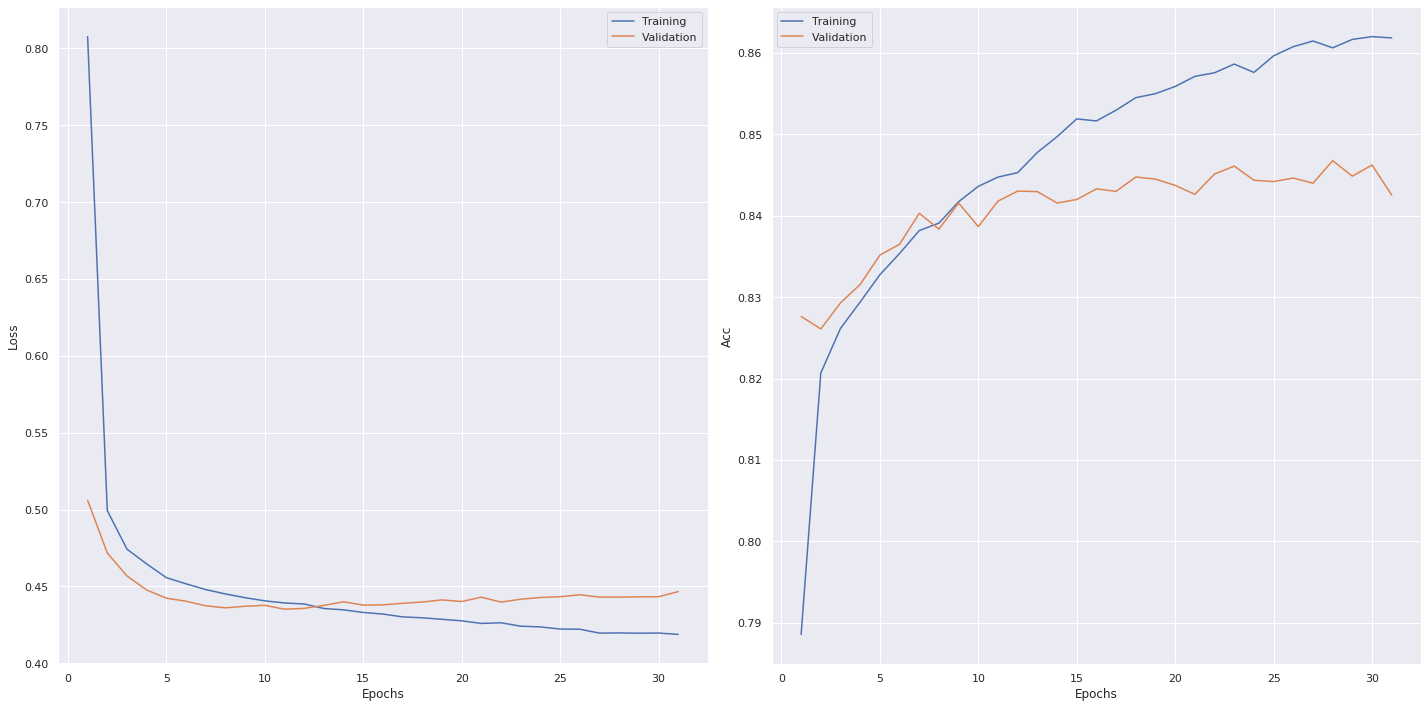

In [23]:
graph(history)

## Evaluation

In [0]:
predictions = model.predict([sentiment_test, test_tfidf])

In [61]:
labels = (predictions > 0.5).astype(np.int) # associa la label corrispondente alla probabilità fornita dal modello
print(classification_report(labels, y_test,digits=3))

              precision    recall  f1-score   support

           0      0.867     0.831     0.849     25952
           1      0.826     0.862     0.844     24048

    accuracy                          0.846     50000
   macro avg      0.846     0.847     0.846     50000
weighted avg      0.847     0.846     0.846     50000

